In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [53]:
books = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Books.csv')
ratings = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Ratings.csv')
users = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Users.csv')


In [20]:
print(books.info())
print(ratings.info())
print(users.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271358 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
 5   Image-URL-S          271360 non-null  object
 6   Image-URL-M          271360 non-null  object
 7   Image-URL-L          271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2),

========== SHAPES ==========
Books shape: (271360, 8)
Ratings shape: (1149780, 3)
Users shape: (278858, 3)

========== MISSING VALUES ==========
Books:
 ISBN                   0
Book-Title             0
Book-Author            2
Year-Of-Publication    0
Publisher              2
Image-URL-S            0
Image-URL-M            0
Image-URL-L            3
dtype: int64

Ratings:
 User-ID        0
ISBN           0
Book-Rating    0
dtype: int64

Users:
 User-ID          0
Location         0
Age         110762
dtype: int64

========== SAMPLE ROWS ==========
Books head:
          ISBN            Book-Title           Book-Author Year-Of-Publication  \
0  0195153448   Classical Mythology    Mark P. O. Morford                2002   
1  0002005018          Clara Callan  Richard Bruce Wright                2001   
2  0060973129  Decision in Normandy          Carlo D'Este                1991   

                 Publisher                                        Image-URL-S  \
0  Oxford University Press

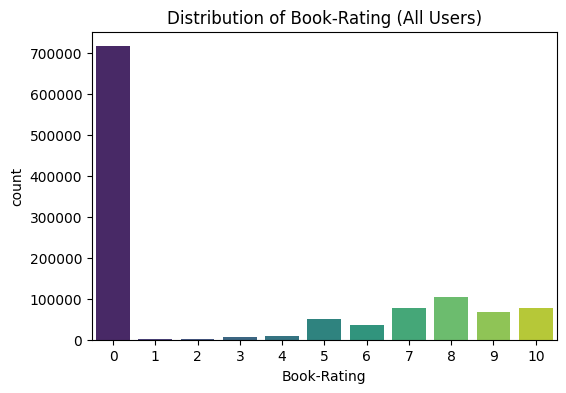

In [21]:
# 3) BASIC EDA (EXPLORATORY DATA ANALYSIS)
print("========== SHAPES ==========")
print("Books shape:", books.shape)
print("Ratings shape:", ratings.shape)
print("Users shape:", users.shape)

print("\n========== MISSING VALUES ==========")
print("Books:\n", books.isna().sum())
print("\nRatings:\n", ratings.isna().sum())
print("\nUsers:\n", users.isna().sum())

print("\n========== SAMPLE ROWS ==========")
print("Books head:\n", books.head(3))
print("\nRatings head:\n", ratings.head(3))
print("\nUsers head:\n", users.head(3))

print("\n========== DISTRIBUTION OF RATINGS ==========")
plt.figure(figsize=(6,4))
sns.countplot(x="Book-Rating", data=ratings, palette="viridis")
plt.title("Distribution of Book-Rating (All Users)")
plt.show()

In [54]:
# 1) DROP THE AGE COLUMN (since we won't use it)
if "Age" in users.columns:
    users.drop(columns=["Age"], inplace=True)
    print("\nDropped 'Age' column from 'users'.")

# 2) DROP ROWS WITH MISSING VALUES IN BOOKS
#    (This will remove rows missing 'Book-Author', 'Publisher', or any other column.)
books.dropna(inplace=True)
print("\nDropped rows with missing values in 'books'.")
print("Books shape after dropna():", books.shape)

# 3) DROP RATINGS WHERE BOOK-RATING == 0
ratings = ratings[ratings["Book-Rating"] != 0]
print("\nDropped rows where Book-Rating == 0.")
print("Ratings shape after dropping 0 ratings:", ratings.shape)

# 4) MERGE THE DATAFRAMES
merged_df = pd.merge(books, ratings, on="ISBN", how="inner")
merged_df = pd.merge(merged_df, users, on="User-ID", how="inner")

print("\nAfter merge, final DataFrame shape:", merged_df.shape)
print("Columns in merged_df:", merged_df.columns.tolist())



Dropped 'Age' column from 'users'.

Dropped rows with missing values in 'books'.
Books shape after dropna(): (271353, 8)

Dropped rows where Book-Rating == 0.
Ratings shape after dropping 0 ratings: (433671, 3)

After merge, final DataFrame shape: (383837, 11)
Columns in merged_df: ['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher', 'Image-URL-S', 'Image-URL-M', 'Image-URL-L', 'User-ID', 'Book-Rating', 'Location']


In [55]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 383837 entries, 0 to 383836
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 383837 non-null  object
 1   Book-Title           383837 non-null  object
 2   Book-Author          383837 non-null  object
 3   Year-Of-Publication  383837 non-null  object
 4   Publisher            383837 non-null  object
 5   Image-URL-S          383837 non-null  object
 6   Image-URL-M          383837 non-null  object
 7   Image-URL-L          383837 non-null  object
 8   User-ID              383837 non-null  int64 
 9   Book-Rating          383837 non-null  int64 
 10  Location             383837 non-null  object
dtypes: int64(2), object(9)
memory usage: 32.2+ MB


In [56]:
# 1) CLEAN YEAR-OF-PUBLICATION ---

merged_df["Year-Of-Publication"] = pd.to_numeric(
    merged_df["Year-Of-Publication"],
    errors='coerce'
)

# Print a few unique values (caution: they might be floats now)
print("\nUnique publication years (sample):",
      sorted(merged_df["Year-Of-Publication"].dropna().unique())[:20], "...")

# Replace weird or missing years (e.g., <1500 or >2025) with NaN
merged_df.loc[
    (merged_df["Year-Of-Publication"] < 1500) |
    (merged_df["Year-Of-Publication"] > 2025),
    "Year-Of-Publication"
] = np.nan

# Drop rows where Year-Of-Publication is NaN
merged_df.dropna(subset=["Year-Of-Publication"], inplace=True)

print("Shape after removing out-of-range publication years:", merged_df.shape)




Unique publication years (sample): [0, 1376, 1378, 1806, 1900, 1901, 1902, 1904, 1906, 1908, 1911, 1920, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930] ...
Shape after removing out-of-range publication years: (378028, 11)



Shape after filtering infrequent users/books: (148732, 11)


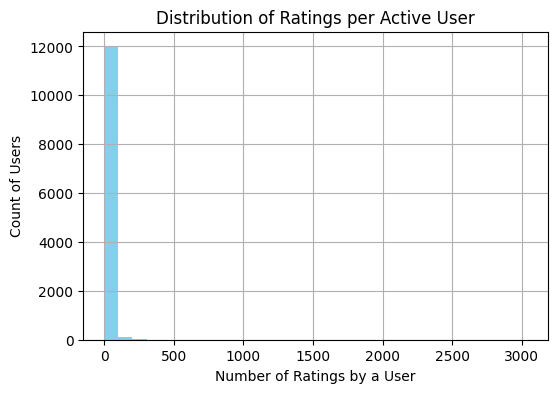

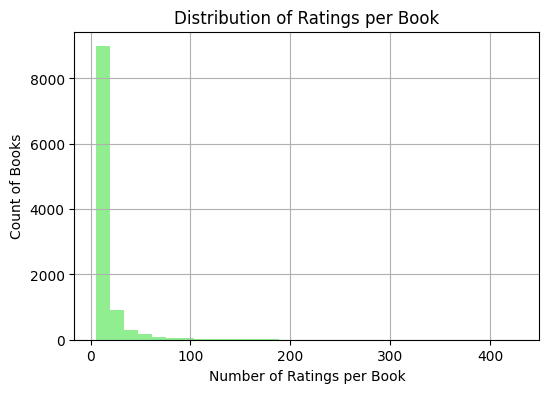

In [57]:
# 1) FILTER OUT USERS WITH FEWER THAN 5 RATINGS
min_user_ratings = 5
user_counts = merged_df["User-ID"].value_counts()
active_users = user_counts[user_counts >= min_user_ratings].index
merged_df = merged_df[merged_df["User-ID"].isin(active_users)]

# 2) FILTER OUT BOOKS WITH FEWER THAN 5 RATINGS
min_book_ratings = 5
book_counts = merged_df["Book-Title"].value_counts()
active_books = book_counts[book_counts >= min_book_ratings].index
merged_df = merged_df[merged_df["Book-Title"].isin(active_books)]

print(f"\nShape after filtering infrequent users/books: {merged_df.shape}")

# 3) OPTIONAL: VISUALIZE DISTRIBUTIONS
plt.figure(figsize=(6,4))
merged_df["User-ID"].value_counts().hist(bins=30, color="skyblue")
plt.title("Distribution of Ratings per Active User")
plt.xlabel("Number of Ratings by a User")
plt.ylabel("Count of Users")
plt.show()

plt.figure(figsize=(6,4))
merged_df["Book-Title"].value_counts().hist(bins=30, color="lightgreen")
plt.title("Distribution of Ratings per Book")
plt.xlabel("Number of Ratings per Book")
plt.ylabel("Count of Books")
plt.show()


## popular


In [59]:
# Compute ratings statistics for each book
pop_stats = merged_df.groupby("Book-Title").agg({
    "Book-Rating": ["count", "mean"]
}).reset_index()
pop_stats.columns = ["Book-Title", "NumRatings", "AvgRating"]

# Compute weighted rating using IMDB formula
C = pop_stats["AvgRating"].mean()  # mean rating across all books
m = pop_stats["NumRatings"].quantile(0.90)  # minimum ratings required

pop_stats["WeightedRating"] = (
    (pop_stats["NumRatings"] / (pop_stats["NumRatings"] + m) * pop_stats["AvgRating"]) +
    (m / (pop_stats["NumRatings"] + m) * C)
)

# Sort by weighted rating
pop_stats.sort_values("WeightedRating", ascending=False, inplace=True)
pop_stats.reset_index(drop=True, inplace=True)

## Item-Based Collaborative Filtering

In [60]:
# Create user-item matrix
item_pivot = merged_df.pivot_table(
    index="User-ID",
    columns="Book-Title",
    values="Book-Rating"
).fillna(0)

# Compute item similarity matrix
item_similarity = cosine_similarity(item_pivot.T.values, item_pivot.T.values)
books_list = item_pivot.columns.tolist()

def get_item_recommendations(book_title, n=5):
    """Get similar books based on user rating patterns"""
    if book_title not in books_list:
        print(f"Book '{book_title}' not found in ratings data")
        return []

    idx = books_list.index(book_title)
    sim_scores = list(enumerate(item_similarity[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:n+1]  # Skip the book itself

    recommended = []
    for i, score in sim_scores:
        book_data = {
            "title": books_list[i],
            "similarity_score": score,
            "avg_rating": pop_stats[pop_stats["Book-Title"] == books_list[i]]["AvgRating"].iloc[0]
        }
        recommended.append(book_data)

    return recommended

## Content-Based Recommendation System

In [61]:
# Create unique books DataFrame with content features
unique_books = merged_df.drop_duplicates(subset=["Book-Title"]).copy()

# Combine features into a rich text representation
unique_books["ContentFeatures"] = (
    unique_books["Book-Author"].fillna("") + " " +
    unique_books["Publisher"].fillna("")
)

# Clean text: remove special chars, convert to lowercase
unique_books["ContentFeatures"] = unique_books["ContentFeatures"].apply(
    lambda x: re.sub(r"[^\w\s]", "", str(x)).strip().lower()
)

# Create TF-IDF vectors
tfidf = TfidfVectorizer(stop_words="english")
content_matrix = tfidf.fit_transform(unique_books["ContentFeatures"])

# Compute content similarity matrix
content_similarity = cosine_similarity(content_matrix, content_matrix)
books_content_list = unique_books["Book-Title"].tolist()

def get_content_recommendations(book_title, n=5):
    """Get similar books based on content features"""
    if book_title not in books_content_list:
        print(f"Book '{book_title}' not found in content data")
        return []

    idx = books_content_list.index(book_title)
    sim_scores = list(enumerate(content_similarity[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:n+1]  # Skip the book itself

    recommended = []
    for i, score in sim_scores:
        book_data = {
            "title": books_content_list[i],
            "similarity_score": score,
            "author": unique_books.iloc[i]["Book-Author"],
            "publisher": unique_books.iloc[i]["Publisher"]
        }
        recommended.append(book_data)

    return recommended


In [62]:
# Get top popular books
print("\nTop 10 Most Popular Books:")
print(pop_stats[["Book-Title", "NumRatings", "AvgRating", "WeightedRating"]].head(10))

# Get recommendations for a specific book
test_book = "The Da Vinci Code"

print(f"\nSimilar books to '{test_book}' based on user ratings:")
item_recs = get_item_recommendations(test_book, n=5)
for rec in item_recs:
    print(f"- {rec['title']} (similarity: {rec['similarity_score']:.3f}, rating: {rec['avg_rating']:.2f})")

print(f"\nSimilar books to '{test_book}' based on content:")
content_recs = get_content_recommendations(test_book, n=5)
for rec in content_recs:
    print(f"- {rec['title']} by {rec['author']} (similarity: {rec['similarity_score']:.3f})")


Top 10 Most Popular Books:
                                          Book-Title  NumRatings  AvgRating  \
0     The Two Towers (The Lord of the Rings, Part 2)         111   9.414414   
1       Harry Potter and the Goblet of Fire (Book 4)         208   9.201923   
2  Harry Potter and the Prisoner of Azkaban (Book 3)         233   9.064378   
3  Harry Potter and the Order of the Phoenix (Boo...         173   9.080925   
4  The Return of the King (The Lord of the Rings,...          94   9.202128   
5                              To Kill a Mockingbird         192   9.026042   
6  Harry Potter and the Sorcerer's Stone (Harry P...         223   8.986547   
7     Harry Potter and the Sorcerer's Stone (Book 1)         140   9.064286   
8   Harry Potter and the Chamber of Secrets (Book 2)         268   8.891791   
9  The Fellowship of the Ring (The Lord of the Ri...         156   8.929487   

   WeightedRating  
0        9.091294  
1        9.036356  
2        8.928600  
3        8.902047  
4 